## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

<h4>General Characteristics of our data</h4>
    
    This will give us a general idea of the given data

In [57]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Number of rows and columns :

In [3]:
df.shape

(294478, 5)

Unique visitors of the webpage :

In [4]:
df.user_id.nunique()

290584

The proportion of users converted :

In [5]:
df.converted.mean()

0.11965919355605512

The number of times the `new_page` and `treatment` don't match :

In [6]:
df1=df.query('group=="treatment"& landing_page=="old_page"')
df1.head()

,user_id,timestamp,group,landing_page,converted
308,857184,2017-01-20 07:34:59.832626,treatment,old_page,0
327,686623,2017-01-09 14:26:40.734775,treatment,old_page,0
357,856078,2017-01-12 12:29:30.354835,treatment,old_page,0
685,666385,2017-01-23 08:11:54.823806,treatment,old_page,0
713,748761,2017-01-10 15:47:44.445196,treatment,old_page,0


Data does not have any missing values :

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  

We will delete such rows from our dataset, two dataframes `f1` and `f2` are created containing <i>treatment</i> and <i>control</i> data respectively.

In [8]:
f1=df.query('group=="treatment"& landing_page=="new_page"')
f2=df.query('group=="control"& landing_page=="old_page"')

A new dataframe `df2` is created :

In [9]:
df2=f1.append(f2)
df2.head()

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [10]:
# Double Checking all of the correct rows were removed
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

How many unique **user_id**s are in **df2** :

In [11]:
df2.user_id.nunique(), df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 2 to 294476
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


(290584, None)

Checking for duplicated `user_id` :

In [12]:
df2[df2['user_id'].duplicated()==True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Row information for both entries :

In [13]:
df2[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Removing the duplicate entry inplace :

In [14]:
df2.drop(index=1899,inplace=True)

The probability of an individual converting regardless of the page they receive :

In [15]:
df2['converted'].mean()

0.11959708724499628

Given that an individual was in the `control` group, what is the probability they converted :

In [16]:
df2.query('group=="control"')['converted'].mean()

0.1203863045004612

Given that an individual was in the `treatment` group, what is the probability they converted :

In [17]:
df2.query('group=="treatment"')['converted'].mean()

0.11880806551510564

Number of individuals recieving new and old pages :

In [18]:
df2.landing_page.value_counts()

new_page    145310
old_page    145274
Name: landing_page, dtype: int64

The control group conversions turn out to be *12.3%* 

The treatment group conversions turn out to be *11.88%*

The analysis done above does not provide enough evidence for us to decide in favour of either the new_page or the old_page.

<a id='ab_test'></a>
### Part II - A/B Test

A hypothesis test could be run based of timestamp given but this could lead to confusion like **When to stop running the test** or **What should be the correct time period so as to get accurate representation?**

For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, 

<i>Null Hypothesis</i> : $p_{new}$ - $p_{old}$ <= 0

<i>Alternative Hypothesis</i> : $p_{new}$ - $p_{old}$ > 0

 Assuming under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Using a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Performing the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>


In [19]:
df2.head()

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


What is the **conversion rate** for $p_{new}$ under the null :

In [20]:
new_conv_rate = round(float(df2.query('converted == 1')['user_id'].nunique())/float(df2['user_id'].nunique()),4)
new_conv_rate

0.1196

What is the **conversion rate** for $p_{old}$ under the null: <br><br>

In [21]:
old_conv_rate = round(float(df2.query('converted == 1')['user_id'].nunique())/float(df2['user_id'].nunique()),4)
old_conv_rate

0.1196

What is $n_{new}$, the number of individuals in the treatment group:

In [22]:
n_new=df2.query('landing_page=="new_page"').user_id.nunique()
n_new

145310

What is $n_{old}$, the number of individuals in the control group:

In [23]:
n_old=df2.query('landing_page=="old_page"').user_id.nunique()
n_old

145274

Simulating $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Storing these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted=np.random.choice([0,1],n_new,p=[new_conv_rate,1-new_conv_rate])

f. Simulating $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Storing these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted=np.random.choice([0,1],n_old,p=[old_conv_rate,1-old_conv_rate])
old_page_converted

array([1, 1, 1, ..., 1, 1, 1])

$p_{new}$ - $p_{old}$ for above simulated data :

In [26]:
obs_diff=new_page_converted.mean()-old_page_converted.mean()
obs_diff

-0.001188430760423187

h. Creating 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process used above. Storing all 10,000 values in a NumPy array called **p_diffs**.

In [27]:
p_diffs=[]
for i in range(10000):
    bootsample=df2.sample(df2.shape[0],replace=True)
    new_page_converted=np.random.choice([0,1],n_new,p=[new_conv_rate,1-new_conv_rate])
    old_page_converted=np.random.choice([0,1],n_old,p=[old_conv_rate,1-old_conv_rate])
    p_diffs.append(new_page_converted.mean()-old_page_converted.mean())

In [28]:
np.array(p_diffs)

array([-0.00022468, -0.00109249, -0.00138832, ..., -0.00028008,
        0.00032555, -0.00025252])

Histogram of `p_diffs` - Depicting effect of Central Limit Theorem

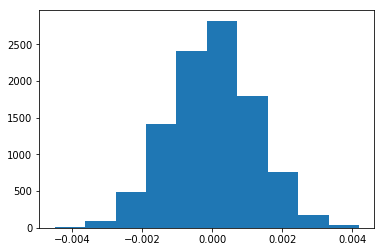

In [29]:
plt.hist(p_diffs);

In [59]:
convert_new = df2.query('converted==1 & landing_page=="new_page"')['user_id'].nunique()
convert_old = df2.query('converted==1 & landing_page=="old_page"')['user_id'].nunique()
new_rate= convert_new/n_new
old_rate=convert_old/n_old

Actual difference observed in ab_data:

In [60]:
act_diff=new_rate-old_rate
act_diff

-0.0015782389853555567

What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv** :

In [30]:
null_vals=np.random.normal(0,np.std(p_diffs),np.size(p_diffs))

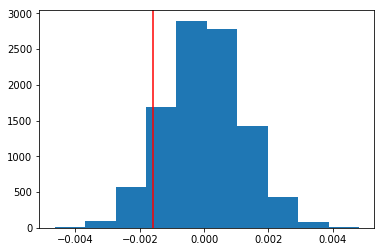

In [61]:
plt.hist(null_vals);
plt.axvline(act_diff,color='red');

In [62]:
(null_vals>act_diff).mean()

0.90429999999999999

What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages :

The P value, or calculated probability, is the probability of finding the observed, or more extreme, results when the null hypothesis (H0) of a study question is true – the definition of ‘extreme’ depends on how the hypothesis is being tested. P is also described in terms of rejecting H0 when it is actually true, however, it is not a direct probability of this state.

The P value in this case in higher than `alpha` i.e. allowed type I error rate. 
Hence we cannot reject the null hypothesis.

This also signifies that <i> There is not a significant difference in the conversion rate when comparing **new_page** and **old_page** </i>

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance.

Statsmodel library is used to determine the z score and p value in this case :

In [56]:
import statsmodels.api as sm

convert_new = df2.query('converted==1 & landing_page=="new_page"')['user_id'].nunique()
convert_old = df2.query('converted==1 & landing_page=="old_page"')['user_id'].nunique()
n_old = n_old
n_new = n_new

Now using `stats.proportions_ztest` to compute your test statistic and p-value.

In [34]:
from statsmodels.stats.proportion import proportions_ztest
stat,p_val=proportions_ztest([convert_new,convert_old],[n_new,n_old], alternative = 'larger')

In [63]:
stat,p_val  # Stat - Critical value of z score

(-1.3109241984234394, 0.90505831275902449)

 What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  

In case of Lower Tailed Z-Test :

Rejection Region for Lower-Tailed Z Test with α =0.05
The decision rule is: Reject H0 if Z < -1.645

In our case Zscore = -1.3109, It is evident that we cannot reject the null hypothesis. This decision matches with the decision taken by sampling above.

<a id='regression'></a>
### Part III - A regression approach

What type of regression must be used?

As our response variable `converted` is categorical, Logistic Regression should be performed to get desirable results.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received. 

In [36]:
df2.head()

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [37]:
df2['intercept']=1
land_page=pd.get_dummies(df2['landing_page'])
df2['ab_page']=pd.get_dummies(df2['group'])['treatment'] #0 when control, 1 when treatment
df2=df2.join(land_page)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,new_page,old_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,1,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,1,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,1,0
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,1,0


Use **statsmodels** to instantiate your regression model on the two columns created above.

In [64]:
lm=sm.Logit(df2['converted'],df2[['intercept','ab_page']])
res=lm.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 09 Aug 2019   Pseudo R-squ.:               8.077e-06
Time:                        07:22:56   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

Summary:

The coefficient related to ab_page implies that there is not a significant difference in conversion rate when new_page or old_page is displayed. 

e. What is the p-value associated with **ab_page**? Why does it differ from the value found in **Part II**?<br><br>  

The p_value associated with ab_page is 0.190
In part II we follow the null hypothesis to be true and then decide whether there is enough evidence in favour of new_page to be actually better.

Whereas in this case we're focusing on the the difference in conversion rate whenever a new_page is displayed. 

The difference in the conversion is not significant as evident by coefficient values.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Other factors could be added in to the model such as different periods of time which could give us a different point of view towards differences in conversion. 

Whereas adding more and more explainatory variables can introduce <i>Multicollinearity</i> into our model. Which would make interpreting results very difficult.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in

A country dataframe is added :

In [39]:
country=pd.read_csv('countries.csv')
country.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


Joining country dataset to our present dataframe :

In [40]:
df3=df2.join(country.set_index('user_id'),on='user_id')
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,new_page,old_page,country
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,1,0,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,1,0,US
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,1,0,CA
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,1,0,UK
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,1,0,CA


Dummy variables are obtained :

In [41]:
cntry=pd.get_dummies(df3['country'])
df3=df3.join(cntry)

Dropping extra columns to maintain rank in dataframe

In [42]:
df3.drop('country',axis=1,inplace=True)

US is taken as a baseline variable

In [43]:
df3.drop('US',axis=1,inplace=True)

In [44]:
df3.drop('old_page',axis=1,inplace=True)

In [45]:
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,new_page,CA,UK
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,1,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,1,0,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,1,1,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,1,0,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,1,1,0


We would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [70]:
lm=sm.Logit(df3['converted'],df3[['intercept','new_page','CA','UK']])
res=lm.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 09 Aug 2019   Pseudo R-squ.:               2.323e-05
Time:                        07:44:29   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
new_page      -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

Interpretting the results :

In [73]:
1/np.exp(-0.0150),np.exp(0.099),np.exp(-0.0408)

(1.0151130646157189, 1.1040662995588819, 0.96002111497165088)

For every unit for new_page decrease, convert will be 1.01% more likely to happen, holding all other varible constant.

 For every unit for UK increases, convert is 1.10% more to happen, holding all other varible constant.
 
 For every unit for CA decreases, convert is 0.96% more to happen, holding all other varible constant.

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split

In [54]:
X=df3[['ab_page']]
y=df3['converted']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=0)


In [55]:
lm=LogisticRegression()
lm.fit(X_train,y_train)
print(lm.score(X_test,y_test))

0.878316528442


A good model score means that the page dataset is good fit for predicting the conversion rate.

<a id='conclusions'></a>
## Conclusion

General Probability, A/B Hypothesis Tests and Regression was performed in order to obtain enough evidence to make an informed decision of choosing either the <b>null</b> or <b>alternative</b> hypothesis

The Country dataset is also associated with our dataframe and effects of users in UK and CA w.r.t US (baseline) on conversion rate is also observed.

In [48]:
#from subprocess import call
#call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])